**Algoritmo K-medias**

In [66]:
import pickle # El módulo pickle implementa un potente algoritmo para serializar y deserializar objetos Python.
import numpy as np

with open('7.10._clustering.pkl', 'rb') as f:
    data_clustering = pickle.load(f)

data_clustering

{'X': array([[ 0.87603609,  0.62413841],
        [-0.59721916, -0.59190989],
        [ 0.51495945, -0.30713853],
        [ 0.7034278 ,  0.28387307],
        [-1.58380208,  0.47433936],
        [-1.89264212, -1.27703905],
        [-1.02176144, -0.38446059],
        [-0.62827134, -2.30814935],
        [-0.71809158,  1.18055509],
        [ 1.3326625 ,  1.50041396],
        [-1.54314377, -1.41637914],
        [ 1.36973405,  0.08368168],
        [ 0.0221037 , -1.12794789],
        [-0.77765189, -0.41575325],
        [ 0.15878937,  0.79493996],
        [-1.20735773, -1.13085237],
        [-1.25958985, -0.44891921],
        [ 1.16168447, -0.22904005],
        [-0.83545665,  0.0704683 ],
        [ 2.08364608,  0.57341134],
        [ 1.33131197,  1.00815304],
        [ 0.76205687,  0.419355  ],
        [-0.77700391, -1.10004302],
        [-1.17619766, -0.11516798],
        [ 1.61888431, -0.81956962],
        [-1.26810263,  0.58652856],
        [ 1.04546445,  0.10600911],
        [ 0.78972191, -

In [67]:
X = np.array(data_clustering['X'])
Y = np.array(data_clustering['Y'])

Visualizamos el DataSet pintando dos grupos en diferentes colores

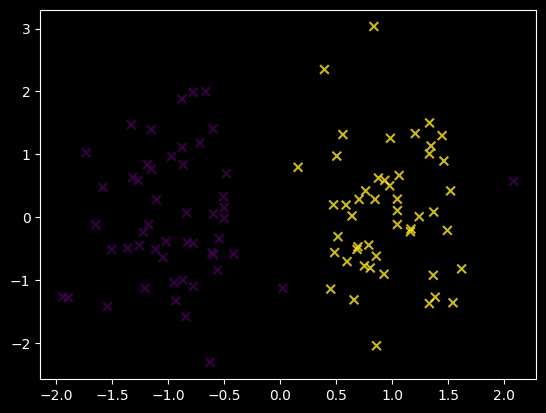

In [68]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='x', alpha=0.8, label='data') # c=Y etiquetas de clúster
plt.show()

Dividimos los puntos en dos clústeres (parámetro n_clusters=2):

C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


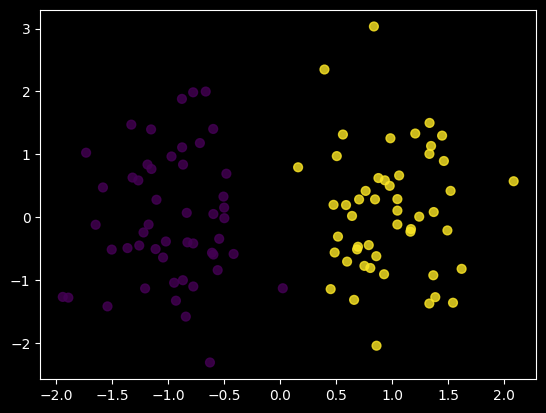

In [69]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(X)

plt.scatter(X[:, 0], X[:, 1], s=40, c=kmeans_model.labels_, marker='o', alpha=0.8, label='data')
plt.show()

*(Selección del número de clústeres k en el algoritmo k-means)*

In [70]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances

metrics = []
MAX_CLUSTERS = 7
for cluster_num in range(1, MAX_CLUSTERS):
    kmeans_model = KMeans(n_clusters=cluster_num, random_state=99).fit(X)
    centroids, labels = kmeans_model.cluster_centers_, kmeans_model.labels_
    metric = 0
    for centroid_label in range(cluster_num):
        metric += euclidean_distances(
            X[labels==centroid_label],
            centroids[centroid_label,:].reshape(1,-1)
        ).sum(axis=0)[0]
    print("cluster_num %s, metric %s" % (cluster_num, metric))
    metrics.append(metric)

cluster_num 1, metric 135.92762259869988
cluster_num 2, metric 92.34245055263457
cluster_num 3, metric 74.52323397050208
cluster_num 4, metric 61.164326241178614
cluster_num 5, metric 54.73583484692996
cluster_num 6, metric 49.74577043379026


C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Visualizamos la dependencia de la métrica en el número de clústeres en el gráfico

best cluster num: 2


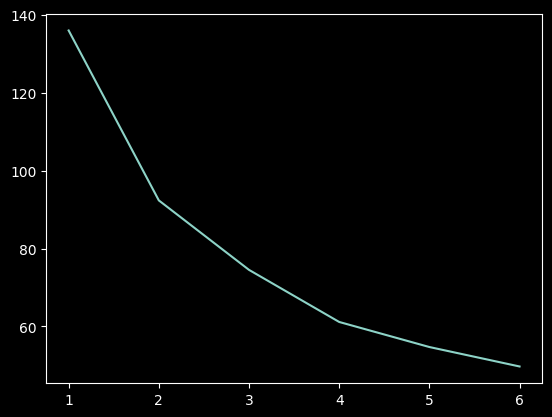

In [71]:
D = []
for i in range(0, len(metrics)-1):
    d = abs(metrics[i+1]-metrics[i])/abs(metrics[i]-metrics[i-1]) # se calcula el coeficiente Dunn para cada número de clústeres
    D.append(d)
print("best cluster num: %s" % (np.argmin(D)+1))

plt.plot([i+1 for i in range(len(metrics))], metrics)
plt.show()

Visualmente, se observa que en el punto k=2 en el gráfico hay una inflexión: este es el mismo "codo". Entonces, el número óptimo de clústeres para nuestro DataSet es **k = 2** 

Construyamos nuestra **implementación de algoritmo** en Python para comprender mejor cómo funciona.

In [72]:
from scipy.spatial.distance import euclidean
from scipy.spatial import distance

def random_centroids_selection(X, n, k):
    """Inicializar aleatoriamente el centro del clúster"""
    result = []
    for obj_id in np.random.randint(0, n, size=k):
        result.append(X[obj_id, :])
    return result


In [73]:
def eval_weight_evolution(centroid_objects_prev, centroid_objects, k):
    """Calculamos cómo se movieron los centros en un paso del algoritmo"""
    result = []
    for i in range(k):
        dist = distance.euclidean(
            centroid_objects_prev[i],
            centroid_objects[i]
        )
        result.append(dist)
    return result


In [74]:
def eval_centroids(X, k, cluster_lables):
    """Calculamos nuevos centroides con el método de promediación de coordenadas"""
    result = []
    for i in range(k):
        new_centroid = X[cluster_lables==i].mean(axis=0)
        result.append(new_centroid)
    return result


In [75]:
def eval_cluster_lables(X, centroid_objects):
    """Calculamos las etiquetas de los clústeres"""
    # formamos una matriz (n x k) que contiene la distancia de cada objeto a cada centroide
    cluster_distance = euclidean_distances(X, centroid_objects)
    # encontramos la distancia mínima en cada línea: será un grupo de objetos
    cluster_lables = cluster_distance.argmin(axis=1)
    return cluster_lables


paso 0, desplazamiento de clústeres: [0.7213534191174558, 1.0480142665088552]
paso 1, desplazamiento de clústeres: [0.07967917794642196, 0.06707457726376119]
paso 2, desplazamiento de clústeres: [0.030261708091210853, 0.030537800022569336]
paso 3, desplazamiento de clústeres: [0.0, 0.0]


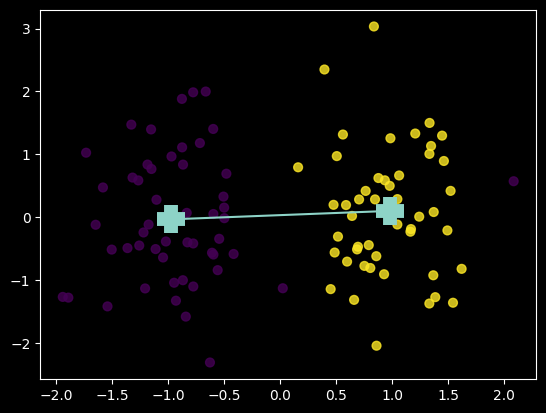

In [76]:
def k_means(X:np.array, k: int=2, eps: float=0.001, num_iteration: int=10) -> np.array:
    """Algoritmo de K-medias
    
    :param X: muestra de entrenamiento
    :param k: número de clústeres
    """
    try:
        n, m = X.shape
    except ValueError:
        print("La muestra de entrenamiento debe ser una matriz bidimensional (n, m) donde m es el Tamaño de la muestra")
    
    # inicializar los centroides con un elemento de muestra aleatorio
    centroid_objects = random_centroids_selection(X, n, k)
    centroid_objects_prev = [np.zeros(m) for i in range(k)]

    # distancia entre la posición anterior y actual de cada centroide
    weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
    step = 0

    # condición de parada: los centroides no han cambiado su posición
    # repetir hasta que se cumpla la condición de parada
    while sum(weight_evolution[i] > eps for i in range(k))!=0 and step < num_iteration:
        centroid_objects_prev = centroid_objects.copy()
        # calculamos las etiquetas de los clústeres
        cluster_lables = eval_cluster_lables(X, centroid_objects)
        # promediamos las coordenadas de los objetos de cada grupo: esta es la nueva posición del centroide
        centroid_objects = eval_centroids(X, k, cluster_lables)
        # calculamos la distancia entre los centroides en iteraciones adyacentes
        weight_evolution = eval_weight_evolution(centroid_objects_prev, centroid_objects, k)
        print("paso %s, desplazamiento de clústeres: %s" % (step, weight_evolution))
        # clústeres actualizados
        step += 1
    return np.vstack(centroid_objects), cluster_lables
    

centroids, labels = k_means(X, k=2, num_iteration=10)

plt.scatter(X[:, 0], X[:, 1], s=40, c=Y, marker='o', alpha=0.8, label='data')
plt.plot(centroids[:, 0], centroids[:, 1], marker='+', mew=10, ms=20)
plt.show()

Implementamos el algoritmo **DBSCAN** usando la biblioteca sklearn
*ventajas: áreas claramente visibles donde la densidad de puntos (cantidad por unidad de área) es mayor que en otras áreas*

In [77]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.6, min_samples=8).fit(X) # eps=0.6 Radio del círculo, min_samples - k

core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

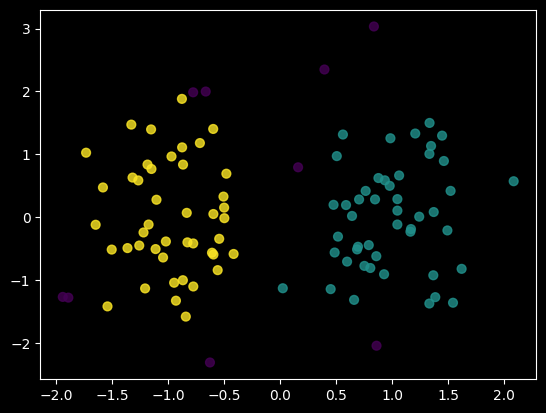

In [78]:
labels = db.labels_
plt.scatter(X[:, 0], X[:, 1], s=40, c=labels, marker='o', alpha=0.8, label='data')
plt.show()

La creación de una máscara booleana ***core_samples_mask*** en este contexto se realiza para resaltar los puntos principales (core samples) que han sido identificados por el algoritmo DBSCAN.

In [79]:
# Suponiendo que db es un objeto DBSCAN que ha sido entrenado
labels = db.labels_

# Mostrar etiquetas únicas y su número
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} puntos")

Cluster -1: 9 puntos
Cluster 0: 47 puntos
Cluster 1: 44 puntos


****Métricas de calidad de agrupamiento****

1) *Coeficiente de silueta*

Aprender K Means-clustering más simple

In [80]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2).fit(X)

C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


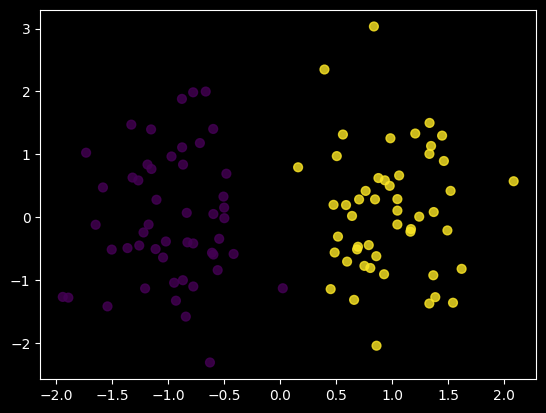

In [81]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], s=40, c=model.labels_, marker='o', alpha=0.8)
plt.show()

Calcular la *métrica de silueta*

In [82]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, model.labels_)

print("Calidad de agrupación por métrica de silueta %.3f" % score)

Calidad de agrupación por métrica de silueta 0.447


más de 0 es bueno, pero menos de 0.5 significa que necesitas mejorar!

entrenamos el modelo con **n_clusters=3**

C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


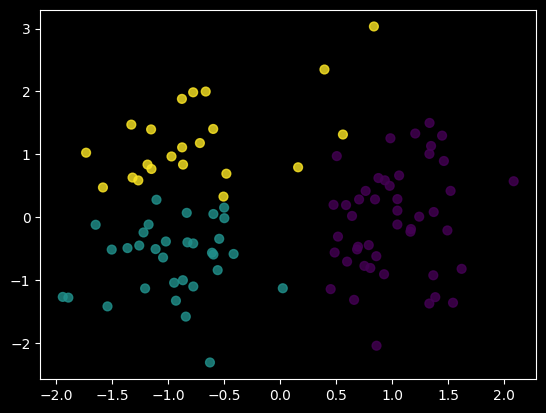

Calidad de agrupación por métrica de silueta 0.452


In [83]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3).fit(X)
plt.scatter(X[:, 0], X[:, 1], s=40, c=model.labels_, marker='o', alpha=0.8)
plt.show()


score = silhouette_score(X, model.labels_)
print("Calidad de agrupación por métrica de silueta %.3f" % score)

la métrica **aumentó**

2) *Adjusted Mutual Information*

C:\Users\Ульяна\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


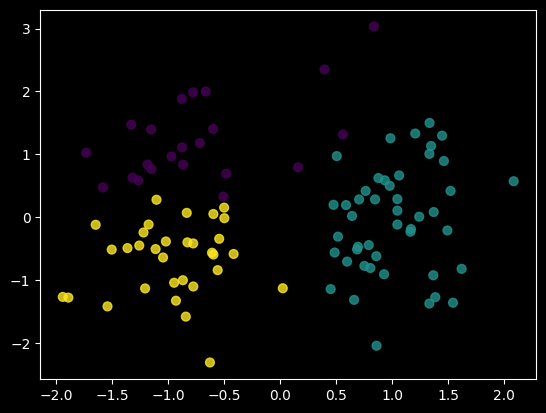

Calidad de agrupación por métrica AMI 0.614


In [84]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

model = KMeans(n_clusters=3).fit(X)
score = adjusted_mutual_info_score(Y, model.labels_, average_method='arithmetic')


plt.scatter(X[:, 0], X[:, 1], s=40, c=model.labels_, marker='o', alpha=0.8)
plt.show()
print("Calidad de agrupación por métrica AMI %.3f" % score)

la agrupación es buena